<a href="https://colab.research.google.com/github/gagyeomkim/Deep-Learning-Paper-Review-and-Practice/blob/main/code_practice/Sequence_to_Sequence_with_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Neural Machine Translation by Jointly Learning to Align and Translate(ICLR 2015) 실습**

- 본 코드에서는 Attention 메커니즘이 적용된 Seq2Seq 모델을 pytorch로 구현합니다.
    - 본 논문은 딥러닝 기반의 자연어 처리 기법의 기본적인 구성을 이해하고 공부하는 데에 도움을 줍니다.
    - 2020년 기준 가장 뛰어난 번역 모델은 Seq2Seq가 아닌 Transformer 기반의 모델입니다.
- 코드 실행 전에 **[런타임] → [런타임 유형 변경]** → 유형을 GPU로 설정합니다.

**GOAL**: 불어 -> 영어로 번역하도록 학습한다.

```text
[KEY: > input, = target, < output]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```

In [ ]:
%matplotlib inline

#### 모듈 Import&데이터로드

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip

--2025-07-12 18:06:29--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.65.3.63, 18.65.3.71, 18.65.3.37, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.65.3.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.05s   

2025-07-12 18:06:29 (56.0 MB/s) - ‘data.zip’ saved [2882130/2882130]



- https://zeuskwon-ds.tistory.com/52

In [ ]:
!unzip -qq "/content/data.zip"

In [ ]:
from __future__ import unicode_literals, print_function, division   # 구버전에서도 상위 버전의 기능을 사용할 수 있게 함
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset,DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### 데이터 전처리

##### Vocabualry 제작

- 단어->색인(word2index)
- 색인->단어(index2word)사전
- 빈도 word2count를 가진 Lang이라는 헬퍼 클래스

In [ ]:
SOS_TOKEN = 0
EOS_TOKEN = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {
            0:"<SOS>",
            1: "<EOS>"
        }
        self.n_words = 2    # SOS와 EOS 포함

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


- 파일이 모두 Unicode로 되어있으므로, 유니 코드 문자를 ASCII로 변환하고
- 모든 문자를 소문자로 만들고
- 대부분의 구두점을 지워줌

In [ ]:
# 유니 코드 문자열을 일반 ASCII로 변환
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD',s)
        if unicodedata.category(c) != 'Mn'
    )

# 소문자 다듬기, 그리고 문자가 아닌 문자 제거
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)   # # .,!,? 문자를 찾아서 자기 자신으로 교체
    s = re.sub(r"[^a-zA-Z!?]+", r" ",s) # # 알파벳이나 !,?가 아닌(^) 모든 문자를 찾아서 공백으로 대체
    return s.strip()

- 파일이 모두 영어->불어이므로 불어->영어로 번역하기 위해 `reverse` flag를 추가하여 단어쌍을 뒤집음

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 파일을 읽고 줄로 분리
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    """
    pairs는 아래와 같은 형태가 됨
    [
        ['i am a student', 'je suis etudiant'],
        ['he is a teacher', 'il est professeur']
    ]
    """

    # 쌍을 뒤집고, Lang instance 생성
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        """
        pairs는 아래와 같은 형태가 됨
        [
            ['je suis etudiant', 'i am a student'],
            ['il est professeur', 'he is a teacher']
        ]
        """
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

- 빠른 학습을 위해 비교적 짧고 간단한 문장으로만 데이터셋을 정리함
    - 최대 10단어 길이의 문장까지(EOS TOKEN 포함)
    - `<I am>` 또는 `<He is>`등의 형태로 번역되는 문장(어파스트로피는 대체됨)

In [ ]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    # p[0]: 불어
    # p[1]: 영어
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH and p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

##### **데이터 준비를 위한 전체 과정**

1. 텍스트 파일을 읽고, 줄로 분리하고, 줄을 쌍으로 분리함
2. 텍스트를 정규화하고 길이와 내용으로 필터링
3. 쌍을 이룬 문장들로 단어 리스트 생성

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991


In [ ]:
print(pairs)
print(random.choice(pairs)) # 지정된 sequence 내의 범주에서 무작위로 1개 선택

[['je vais bien', 'i m ok'], ['ca va', 'i m ok'], ['je suis gras', 'i m fat'], ['je suis gros', 'i m fat'], ['je suis en forme', 'i m fit'], ['je suis touche !', 'i m hit !'], ['je suis touchee !', 'i m hit !'], ['je suis malade', 'i m ill'], ['je suis triste', 'i m sad'], ['je suis timide', 'i m shy'], ['je suis mouille', 'i m wet'], ['je suis mouillee', 'i m wet'], ['il est mouille', 'he s wet'], ['je suis gras', 'i am fat'], ['je suis revenu', 'i m back'], ['me revoila', 'i m back'], ['je suis chauve', 'i m bald'], ['je suis occupe', 'i m busy'], ['je suis occupee', 'i m busy'], ['je suis calme', 'i m calm'], ['j ai froid', 'i m cold'], ['j en ai fini', 'i m done'], ['tout va bien', 'i m fine'], ['je vais bien', 'i m fine'], ['ca va', 'i m fine'], ['je suis libre !', 'i m free !'], ['je suis libre', 'i m free'], ['je suis disponible', 'i m free'], ['je suis repu !', 'i m full'], ['je suis rassasie !', 'i m full'], ['je suis content', 'i m glad'], ['je suis chez moi', 'i m home'], ['

##### 학습 데이터 준비

각 쌍마다 입력 tensor와 목표 tensor가 필요함
- 입력 Tensor(입력 문장의 단어 주소)
- 목표 Tensor(목표 문장의 단어 주소)

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_TOKEN)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype = np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype = np.int32)

    # 각 pair마다 EOS TOKEN 추가
    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_TOKEN)
        tgt_ids.append(EOS_TOKEN)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

#### Seq2Seq 모델

##### 인코더

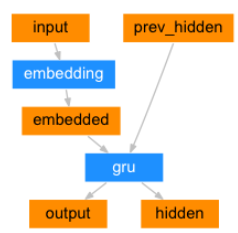

Drawing 2025-07-13 01.46.00.excalidraw.svg

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN,self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        # input: (batch_size, seq_len)
        embedded = self.dropout(self.embedding(input))
        #embedded: (batch_size, seq_len, embedding_dim)
        output, hidden = self.gru(embedded)
        # output: (batch_size, seq_len, bidirectional(1)*hidden_size)
        # hidden: (bidirectional(1)*number of layers(1), batch_size, hidden_size)   <- batch_first여도 동일
        return output, hidden

###### **Embedding layer의 입출력 shape에 대한 이해**

- `nn.Dropout(p)`: 'training' 동안 입력 텐서의 일부 요소를 확률로 무작위로 0으로 설정

In [ ]:
# 0부터 input_lang.n_words -1 사이의 정수로 텐서 생성
x = torch.randint(0, input_lang.n_words,(16, 10))    # (batch_size, seq_len)

input_size = input_lang.n_words
hidden_size = 32

print(x.shape)
embedding = nn.Embedding(input_size, hidden_size)
dropout = nn.Dropout(0.1)

embedded = embedding(x)
print(embedded.shape)

# dropout: input은 어떤 모양이든 가능. output은 인풋과 동일한 모양
embedded = dropout(embedded)
print(embedded.shape)

torch.Size([16, 10])
torch.Size([16, 10, 32])
torch.Size([16, 10, 32])


###### **gru layer의 입출력 shape에 대한 이해**

In [ ]:
gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
output, hidden = gru(embedded)
print(output.shape) # output: (batch_size, seq_len, bidirectional(1) * hidden_size)
print(hidden.shape) # hidden: (bidirectional(1) * number of layers(1) ,batch_size, hidden_size)

torch.Size([16, 10, 32])
torch.Size([1, 16, 32])


###### **Encoder의 입출력 shape에 대한 이해**

In [ ]:
encoder = EncoderRNN(input_size, hidden_size, 0.1)
output, hidden = encoder(x)
print(output.shape)
print(hidden.shape)

torch.Size([16, 10, 32])
torch.Size([1, 16, 32])


##### **Attention 디코더**

- **Bahdanau Attention**을 구현해볼 것

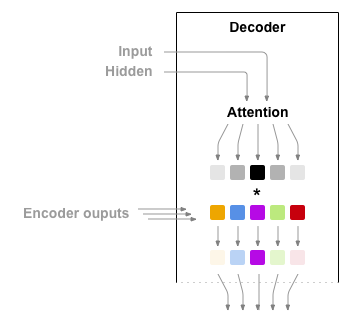

- Attention 가중치 계산은 또다른 feed-forward 계층인 `attn`으로 구현될 것


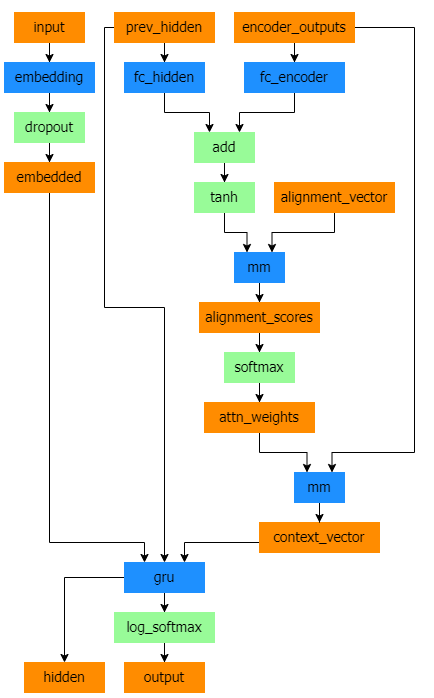

Drawing 2025-07-12 22.29.53.excalidraw.svg

- 초기 입력 토큰: `<SOS>` 토큰
- 첫 hidden state: Context Vector(Encoder의 마지막 hidden state)

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        """
        query: Encoder의 마지막 hidden state => (batch_size, bidirectional(1)*number of layers(1), hidden_size)
        keys: Encoder의 outputs => (batch_size, seq_len, bidirectional(1) * hidden_size)
        """
        # print(f'self.Wa(query).shape: {self.Wa(query).shape}')
        # print(f'self.Ua(keys).shape: {self.Ua(keys).shape}')

        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        # print(f'scores.shape: {scores.shape}')

        scores = scores.squeeze(2).unsqueeze(1)
        # print(f'scores.shape: {scores.shape}')

        weights = F.softmax(scores, dim=-1) # 마지막 차원에 대해서 softmax 적용
        # print(f'weights.shape: {weights.shape}')

        # torch.bmm: batch가 존재하는 matrix-matrix간의 곱셈 수행
        context = torch.bmm(weights, keys)  # 인자: (input, mat2) => 결과값(output)
        # print(context.shape)
        # weights: (batch_size, 1, seq_len) = (16, 1, 1)
        # keys: (batch_size, seq_len(1), 32)
        # context: (batch_size, 1, 32)  -> 문장마다 32차원의 문맥벡터를 가짐

        return context, weights

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size) # attention 가중치 계층
        self.gru = nn.GRU(2*hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_TOKEN)    # decoder_input: (batch_size, 1)
        decoder_hidden = encoder_hidden # decoder_hidden: (bidirectional(1)*number of layers(1), batch_size, hidden_size)
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH): # 단어 개수만큼 반복
            # decoder_output: (batch_size, 1, output_size)  # input에 대해서, 다음 단어에 대한 score 완성
            # decoder_hidden: (bidirectional(1)*number of layers(1), batch_size, hidden_size)
            # attn_weights: (batch_size, 1, seq_len(10))
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing 포함: 목표를 다음 입력으로 전달
                decoder_input = target_tensor[:, i].unsqueeze(1)    # teacher forcing
            else:
                # Teacher forcing 미포함: 자신의 예측을 다음 입력으로 사용
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()   # 입력으로 사용할 부분을 히스토리에서 분리

        # decoder_outputs = (batch_size, MAX_LENGTH, output_size)
        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)    # 확률분포로 전환

        # attentions: (batch_size, MAX_LENGTH, seq_len(10))    <- 각 토큰별로 attention value 획득
        attentions = torch.cat(attentions, dim=1)   # attention 안에 있는 요소들에 대해서, 1번째 차원에 대해서 합침 -> (batch_size, 1, seq_len)이니까 1번째 차원인 열에 대해서 합침
                                                            # MAX_LENGTH: 최대 문장 길이(=디코더의 출력 시퀀스의 길이), seq_len: 인코더의 입력 시퀀스의 길이
                                                            # attention[i][j][k]: i번째 문장에서 디코더의 j번째 토큰이 인코더의 k번째 토큰에 얼마나 주의를 기울였는지를 나타내는 값

        # decoder_outputs = (batch_size, MAX_LENGTH, output_size)
        # decoder_hidden: (bidirectional(1)*number of layers(1), batch_size, hidden_size)
        # attentions: (batch_size, MAX_LENGTH, seq_len(10))
        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        """
        input: (batch_size, 1)
        hidden: (bidirectional(1)*number of layers(1), 1, hidden_size)
        encoder_outputs: (batch_size, seq_len, hidden_size)
        """
        #embedded: (batch_size, 1, embedding_dim)
        embedded = self.dropout(self.embedding(input))

        # query: (batch_size, bidirectional(1)*number of layers(1), hidden_size)
        query = hidden.permute(1, 0, 2)

        # context:  (batch_size, 1, hidden_size)
        # attn_weights: (batch_size, 1, seq_len(10))
        context, attn_weights = self.attention(query, encoder_outputs)

        # input_gru = (batch_size, 1, embedding_dim(해당 예제에서는 hidden_size와 동일한 값) + hidden_size = 2*hidden_size)
        input_gru = torch.cat((embedded, context), dim=2)   # 2차원에 대해서 torch.cat

        # output: (batch_size, 1, hidden_size*bidirectional(1))
        # hidden: (bidirectional(1)*number of layers(1), batch_size, hidden_size)
        output, hidden = self.gru(input_gru, hidden)


        output = self.out(output)
        # output: (batch_size, 1, output_size)  # input에 대해서, 다음 단어에 대한 score 완성

        # output: (batch_size, 1, output_size)  # input에 대해서, 다음 단어에 대한 score 완성
        # hidden: (bidirectional(1)*number of layers(1), batch_size, hidden_size)
        # attn_weights: (batch_size, 1, seq_len(10))
        return output, hidden, attn_weights



###### **Bahdanau attention 이해**

In [ ]:
hidden_size=32
Wa = nn.Linear(hidden_size, hidden_size)
Ua = nn.Linear(hidden_size, hidden_size)
Va = nn.Linear(hidden_size, 1)

# hidden: (bidirectional(1)*number of layers(1),batch_size,hidden_size) = (1, 16, 32)
# query: (batch_size, bidirectional(1)*number of layers(1), hidden_size) = (16, 1, 32)
query = hidden.permute(1, 0, 2)
print(query.shape)

# keys(encoder_output) : (batch_size, seq_len, hidden_size*bidirectional(1)) = (16, 10, 32)
keys = output
print(keys.shape)

print(f'self.Wa(query).shape: {Wa(query).shape}')   # 크기는 안변하고 가중만 줌
print(f'self.Ua(keys).shape: {Ua(keys).shape}') # 크기는 안변하고 가중만 줌

# scores: (batch_size, seq_len(10), 1)
scores = Va(torch.tanh(Wa(query) + Ua(keys)))
print(f'tanh((Wa(query) + Ua(keys))).shape: {torch.tanh((Wa(query) + Ua(keys))).shape}')
print(f'scores.shape: {scores.shape}')

#socres: (batch_size, seq_len(10), 1) -> (batch_size, 1 ,seq_len(10))
scores = scores.squeeze(2).unsqueeze(1)
print(f'scores.shape: {scores.shape}')

# 마지막 차원(단어마다 가지는 attention Score)에 대해서 softmax 적용하여 확률분포로 만듦
# 즉, 각 단어마다 영향을 가중치로 표시함
weights = F.softmax(scores, dim=-1)
print(f'weights.shape: {weights.shape}')

# torch.bmm: batch가 존재하는 matrix-matrix간의 곱셈 수행
# 인자: (input, mat2) => 결과값(output)
# weights: (batch_size, 1, seq_len(10)) = (16, 1, 10)
# keys: (batch_size, seq_len(10), 32)
# context: (batch_size, 1, 32)  -> 문장마다 32차원의 문맥벡터를 가짐
context = torch.bmm(weights, keys)
print(context.shape)


torch.Size([16, 1, 32])
torch.Size([16, 10, 32])
self.Wa(query).shape: torch.Size([16, 1, 32])
self.Ua(keys).shape: torch.Size([16, 10, 32])
tanh((Wa(query) + Ua(keys))).shape: torch.Size([16, 10, 32])
scores.shape: torch.Size([16, 10, 1])
scores.shape: torch.Size([16, 1, 10])
weights.shape: torch.Size([16, 1, 10])
torch.Size([16, 1, 32])


###### **Decoder의 embedding layer의 입출력 shape에 대한 이해**

- decoder의 input은 1단어씩 들어온다

In [ ]:
# 배치크기가 16이라고 가정한경우
x = torch.randint(0, input_lang.n_words,(16, 1))    # 0부터 input_lang.n_words -1 사이의 정수로 텐서 생성
input_size = input_lang.n_words
hidden_size = 32
embedding = nn.Embedding(input_size, hidden_size)
dropout = nn.Dropout(0.1)

# x: (batch_size, seq_len(1)) -> decoder의 input은 1개씩 들어옴.
print(x.shape)

# embedded = (batch_size, 1, embedding_dim(해당 예제에서는 hidden_size와 값이 동일))
embedded = embedding(x)
print(embedded.shape)

# dropout: input은 어떤 모양이든 가능. output은 인풋과 동일한 모양
# embedded = (batch_size, 1, embedding_dim(해당 예제에서는 hidden_size와 값이 동일))
embedded = dropout(embedded)
print(embedded.shape)

torch.Size([16, 1])
torch.Size([16, 1, 32])
torch.Size([16, 1, 32])


###### **attention layer의 입출력 shape에 대한 이해**

In [ ]:
print(embedded.shape)
print(embedded[0])

print(context.shape)
print(context[0])

input_gru = torch.cat((embedded, context), dim=2)
print(input_gru[0])
input_gru.shape # dim=2에서 embedded 뒤에 따라서 바로 붙은거 확인 가능

torch.Size([16, 1, 32])
tensor([[ 0.3435,  0.0600,  0.8200,  0.1099, -0.7565,  0.8822, -0.3804, -0.3162,
          0.3122,  1.2989, -1.5504,  1.2186, -1.0718,  1.7688, -1.0680,  0.6123,
         -0.0000,  1.1077,  2.7479, -0.9618,  0.0000, -0.5961, -1.6911,  1.0397,
          0.5863, -2.5894, -0.7075, -0.2892,  0.0778,  0.9513, -1.9192,  0.2317]],
       grad_fn=<SelectBackward0>)
torch.Size([16, 1, 32])
tensor([[ 0.1904,  0.0889,  0.0040,  0.1101, -0.0405,  0.1126, -0.1381, -0.1032,
          0.1469, -0.0009,  0.1577,  0.0396,  0.0412, -0.1571,  0.2646,  0.2407,
         -0.0945, -0.0628,  0.0121,  0.2129, -0.0129,  0.0256,  0.1664, -0.1158,
         -0.1024,  0.0664, -0.0383,  0.1698,  0.3241, -0.1253, -0.0438, -0.0739]],
       grad_fn=<SelectBackward0>)
tensor([[ 3.4352e-01,  5.9994e-02,  8.2002e-01,  1.0987e-01, -7.5647e-01,
          8.8218e-01, -3.8040e-01, -3.1625e-01,  3.1216e-01,  1.2989e+00,
         -1.5504e+00,  1.2186e+00, -1.0718e+00,  1.7688e+00, -1.0680e+00,
          

torch.Size([16, 1, 64])

#### 모델 학습

In [ ]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
# 한 epoch에 대한 train 함수
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data
        # input_tensor: 입력 문장 - (batch_size, seq_len)
        # target_tensor: 출력 문장 - (batch_size, MAX_LENGTH) - 단어가 아닌 정수인덱스된 "문장"
        # print(f'input_tensor.shape: {input_tensor.shape}')
        # print(f'input_tensor.shape: {input_tensor.shape}')

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            # decoder_outputs = (batch_size, MAX_LENGTH, output_size(output_lang.n_words)) -> (batch_size * MAX_LENGTH, output_size)
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)  # (batch_size * MAX_LENGTH)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()   # batch마다의 loss를 더함

    return total_loss / len(dataloader) # len(dataloader)=총 배치의 개수. 나누어서 모든 batch에 대해서 평균 loss를 구함

###### **criterion의 입력 shape 이해**

In [ ]:
input_lang, output_lang, train_dataloader = get_dataloader(32)  # batch_size: 32

for data in train_dataloader:
    input_tensor, target_tensor = data
    # input_tensor: 입력 데이터 - (batch_size, seq_len)
    # target_tensor: 출력 데이터 - (batch_size, MAX_LENGTH)
    print(f'input_tensor.shape: {input_tensor.shape}')
    print(f'target_tensor.shape: {target_tensor.shape}')
    print(target_tensor)    # 단어가 아닌 정수인덱스된 "문장". -> (batch_size, MAX_LENGTH)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
        [  74,   39,  763,   23,  101,  293, 1803,    1,    0,    0],
        [  74,   39,  535,    1,    0,    0,    0,    0,    0,    0],
        [ 128,   77, 1527,  756, 1644, 1167,  377,    1,    0,    0],
        [  13,   14,   41,  459,   55,    1,    0,    0,    0,    0],
        [   2,    3,  101,  102,    1,    0,    0,    0,    0,    0]],
       device='cuda:0')
input_tensor.shape: torch.Size([32, 10])
target_tensor.shape: torch.Size([32, 10])
tensor([[ 128,   77,  302,  718,    1,    0,    0,    0,    0,    0],
        [ 128,   77,  146,  108,    1,    0,    0,    0,    0,    0],
        [  13,   14,  144,  586,    1,    0,    0,    0,    0,    0],
        [ 128,   77,  302, 1138,  563,  537,  128, 1050,    1,    0],
        [  74,   14, 1859,  217,  828,    1,    0,    0,    0,    0],
        [ 128,   77,  568,    1,    0,    0,    0,    0,    0,    0],
        [   2,    3,  359,  517, 2037,  671,    1,    0,    0,    0],
        [   2,  

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')   # 화면에 직접 그림을 표시하지 않고(non-interactive) 이미지 파일(예: PNG)로만 저장할 수 있게 해주는 백엔드
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격으로 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)  # 0.2의 배수가 되는 위치마다 눈금을 표시
    ax.yaxis.set_major_locator(loc) # y축의 주 눈금(major_locator)로 설정
    plt.plot(points)    # 입력받은 points(=loss) 데이터를 사용해 선 그래프를 그림. 인자가 1개면 기본적으로 y축에 들어가고 0값은 순서대로 자동으로 (0,1,2,...)가 됨

In [ ]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        # epoch마다 loss 구함
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
0m 38s (- 9m 39s) (5 6%) 1.5507
1m 18s (- 9m 7s) (10 12%) 0.6875
1m 56s (- 8m 26s) (15 18%) 0.3574
2m 35s (- 7m 47s) (20 25%) 0.1980
3m 14s (- 7m 7s) (25 31%) 0.1206
3m 52s (- 6m 28s) (30 37%) 0.0829
4m 31s (- 5m 49s) (35 43%) 0.0623
5m 10s (- 5m 10s) (40 50%) 0.0511
5m 48s (- 4m 31s) (45 56%) 0.0445
6m 27s (- 3m 52s) (50 62%) 0.0391
7m 5s (- 3m 13s) (55 68%) 0.0374
7m 44s (- 2m 34s) (60 75%) 0.0347
8m 23s (- 1m 56s) (65 81%) 0.0331
9m 1s (- 1m 17s) (70 87%) 0.0314
9m 40s (- 0m 38s) (75 93%) 0.0303
10m 18s (- 0m 0s) (80 100%) 0.0291


##### 모델 평가

In [ ]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        # input_tensor: (batch_size(1), seq_len)
        input_tensor = tensorFromSentence(input_lang, sentence)

        # encoder_outputs: (batch_size, seq_len, bidirectional(1) * hidden_size)
        # hidden: (bidirectional(1)*number of layers(1), batch_size, hidden_size)
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        # decoder_outputs = (batch_size, MAX_LENGTH, output_size)
        # decoder_hidden: (bidirectional(1)*number of layers(1), batch_size, hidden_size)
        # attentions: (batch_size, MAX_LENGTH, seq_len(10))
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        # decoder_outputs = (batch_size, MAX_LENGTH, output_size)
        # topi: (1, MAX_LENGTH, 1)
        _, topi = decoder_outputs.topk(1)   #  .topk(k): decoder_outputs에서 가장 큰 1개의 value값과 index를 뽑아주는 함수
                                            # dimension이 주어지지 않았으므로, 마지막 차원에 대해서 뽑음
                                            # 즉, 각 토큰에 대해서, 가장 확률이 높은 단어를 뽑음
        # print(f'decoder_outputs.shape: {decoder_outputs.shape}')
        # print(f'topi: {topi}')
        # print(f'topi.shape: {topi.shape}')
        decoded_ids = topi.squeeze()    # decoded_ids: (MAX_LENGTH) - 각 토큰에 대해서, 예측 확률이 가장 높은 단어의 인덱스가 저장되어있음
        # print(f'decoded_ids: {decoded_ids}')
        # print(f'decoded_ids.shape: {decoded_ids.shape}')

        decoded_words = []
        for idx in decoded_ids:  # decoded_ids는 tensor이고, idx도 tensor(value) 형태라 idx.item()으로 가져와야함
            if idx.item() == EOS_TOKEN:
                decoded_words.append('<EOS>')   # 마지막에 <EOS>토큰을 추가하고 종료
                break
            decoded_words.append(output_lang.index2word[idx.item()])    # idx로부터 value를 가져와서 word로 바꾼 뒤, 출력용 리스트에 저장
    return decoded_words, decoder_attn

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs) # pairs에서 아무거나 가져옴
        print('>', pair[0]) # input
        print('=', pair[1]) # target
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence) # output
        print('')

In [ ]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> tu es etourdi
= you re forgetful
< you re forgetful <EOS>

> je suis presque aussi grand que mon pere maintenant
= i am about as big as my father now
< i am about as big as my father now <EOS>

> je suis aussi age que vous
= i m as old as you
< i m as old as you <EOS>

> je ne suis pas fatigue moi non plus
= i am not tired neither am i
< i am not tired neither am i <EOS>

> elle est appreciee de tout le monde
= she is appreciated by everyone
< she is appreciated by everyone <EOS>

> c est ici qu il joue
= he is playing here
< he is playing here <EOS>

> tu fais partie du probleme
= you re part of the problem
< you re part of the problem <EOS>

> nous connaissons la reussite
= we re successful
< we re successful <EOS>

> il ne porte pas de chapeau
= he is not wearing a hat
< he is not wearing a hat <EOS>

> je suis en train de lire le journal
= i m reading the newspaper
< i m reading the newspaper <EOS>



##### Attention 시각화

input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>


/tmp/ipython-input-34-2253364921.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipython-input-34-2253364921.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


<Figure size 640x480 with 0 Axes>

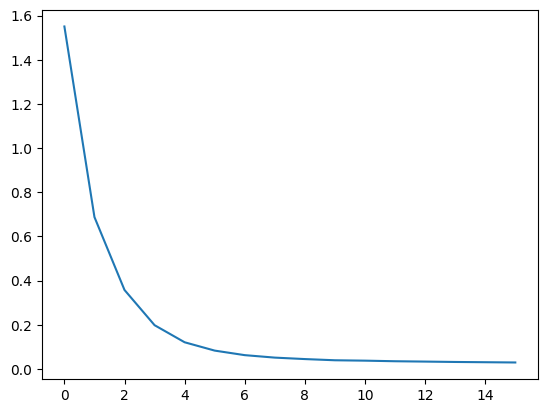

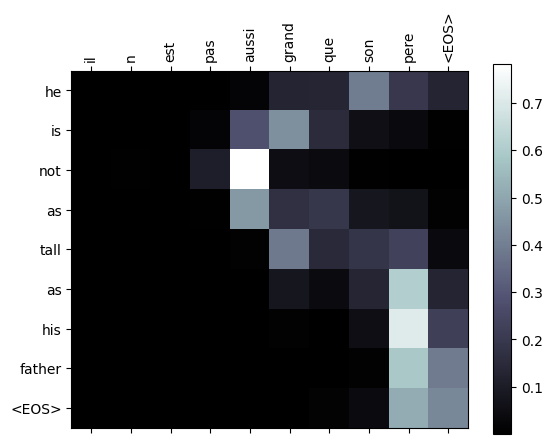

input = je suis trop fatigue pour conduire
output = i m too tired to drive to drive <EOS>


/tmp/ipython-input-34-2253364921.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipython-input-34-2253364921.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


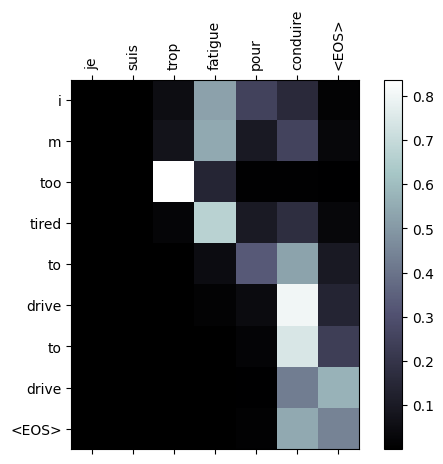

input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>


/tmp/ipython-input-34-2253364921.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipython-input-34-2253364921.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


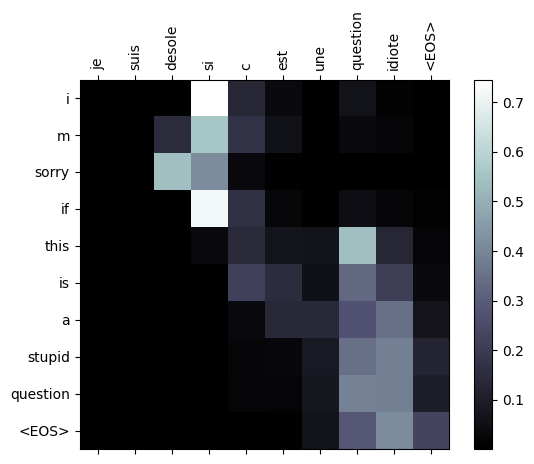

input = je suis reellement fiere de vous
output = i m really proud of you <EOS>


/tmp/ipython-input-34-2253364921.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipython-input-34-2253364921.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


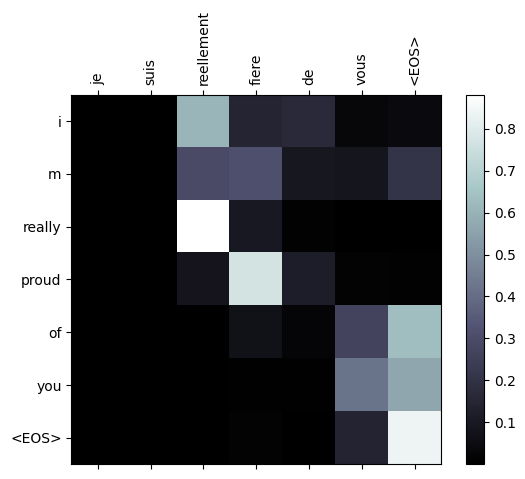

In [ ]:
%matplotlib inline
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))   # x축에 1의 배수가 되는 위치마다 눈금 표시
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))   # y축에 1의 배수가 되는 위치마다 눈금 표시

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')